In [60]:
fff=!pwd
print(fff[0]+"/calculate_similarities.ipynb")

/workspace/02_cha_drug_repositioning/calculate_similarities.ipynb


In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [62]:
import numpy as np
import pandas as pd
import copy
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt

from cmapPy.pandasGEXpress.parse import parse
from cmapPy.pandasGEXpress.write_gct import write
from cmapPy.pandasGEXpress.GCToo import GCToo
from cmapPy.pandasGEXpress.gctx2gct import gctx2gct_main

import torch

import warnings
warnings.filterwarnings('ignore')

In [63]:
from super_classes import param_class as param_class_module
from utils import data_processing as data_processing_module
from utils import data_load as data_load_module
from run import train as train_module
from run import test_model as test_model_module

# Configure parameters

In [64]:
BASE_DIR="/workspace/02_cha_drug_repositioning"
EMBEDDING_PATH="/result_files/embedding_vectors.pkl"

In [65]:
configurable_parameters_dict={
  "BASE_DIR":BASE_DIR,
  "EMBEDDING_PATH":EMBEDDING_PATH
}

# Load data

In [66]:
loaded_embedding=data_load_module.Utils_Data_Load.load_embedding(BASE_DIR,EMBEDDING_PATH)

# Delete columns

In [67]:
loaded_embedding_remove_unnecessary_cols=loaded_embedding.drop(columns=['drug','drug_num'])

In [68]:
loaded_embedding_remove_unnecessary_cols.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,drug_string
0,-0.195774,0.208246,-0.200245,-0.187345,0.298707,0.040652,0.061265,-0.110596,-0.346074,0.210854,...,0.022476,0.114534,0.307462,-0.020733,-0.225425,0.030660,0.184458,-0.164767,-0.155291,aminoguanidine
1,-0.206023,0.269305,-0.164176,-0.130092,0.278392,0.169211,0.038797,0.001637,-0.306482,0.227568,...,-0.092902,0.138725,0.222398,-0.084328,-0.189538,-0.044626,0.102906,-0.163264,-0.166390,aminoguanidine
2,-0.229680,0.280046,-0.207327,-0.124709,0.297977,0.150674,0.027637,-0.020915,-0.310484,0.231743,...,-0.082762,0.108592,0.265966,-0.094301,-0.186188,-0.023070,0.143695,-0.171468,-0.126361,aminoguanidine
3,-0.180996,0.208216,-0.170820,-0.186510,0.247666,0.029806,0.105625,-0.109963,-0.337048,0.207076,...,0.024517,0.107074,0.310967,-0.007454,-0.198819,0.079107,0.202584,-0.176205,-0.174298,aminoguanidine
4,-0.292073,0.245195,-0.254652,-0.015646,0.319038,0.075625,0.082516,-0.164901,-0.271635,0.129995,...,0.111686,0.043952,0.327192,-0.014980,-0.095702,-0.060707,0.080241,-0.093569,-0.150556,aminoguanidine


# Make average vectors of drugs

In [69]:
average_vectors_of_drugs=loaded_embedding_remove_unnecessary_cols.groupby('drug_string').mean()

In [70]:
average_vectors_of_drugs

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
drug_string,,,,,,,,,,,,,,,,,,,,,
"1,2-dichlorobenzene",0.142526,0.094189,0.049085,-0.037601,-0.176388,0.052995,-0.167411,0.195373,0.200979,-0.173323,...,0.098197,-0.096802,-0.043737,0.100694,0.218770,-0.015976,0.023751,0.098490,0.123129,0.141576
1-benzylimidazole,0.039313,-0.288197,-0.090358,-0.340095,0.014232,-0.002763,-0.146777,0.081335,0.135339,0.201044,...,-0.009125,-0.002706,0.131882,-0.083440,0.099483,-0.183292,0.017452,0.139323,-0.128288,-0.063953
10-DEBC,-0.063105,-0.049956,-0.071135,0.038525,0.077832,-0.057737,-0.053786,-0.032214,-0.117555,0.108481,...,-0.068887,0.079205,-0.060787,-0.002825,-0.008383,0.076846,-0.025750,-0.022077,-0.178901,-0.178837
10H-phenothiazin-10-yl)(p-tolyl)methanone,-0.046609,-0.052728,-0.067018,-0.184431,-0.038483,0.144161,-0.098388,0.198902,0.235310,0.060872,...,0.078778,-0.218595,0.127017,-0.068503,0.032991,-0.139125,0.027769,0.031773,0.112545,0.154941
15-delta-prostaglandin-j2,-0.154486,-0.173048,0.192556,-0.005826,0.124196,-0.099334,0.046207,0.236186,0.190813,-0.137180,...,-0.131142,-0.195511,0.069686,-0.102877,0.004742,-0.022269,-0.096506,-0.140976,0.132734,0.011082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zolpidem,0.054298,0.179949,-0.030865,0.086506,-0.170085,0.139300,0.007351,0.117831,-0.047991,0.064896,...,-0.015242,-0.153002,-0.019073,-0.114844,-0.001296,0.037288,0.083127,-0.062738,-0.021872,-0.051104
zonisamide,-0.009462,-0.011216,0.037316,0.056547,-0.172883,0.114010,-0.051378,-0.034142,0.089025,0.086834,...,0.110079,0.026111,0.086760,-0.100793,0.120552,0.074810,0.130676,-0.062494,0.071158,-0.045081
zosuquidar,0.215944,0.085175,0.146672,-0.028842,-0.104609,-0.059954,0.097361,-0.143745,-0.103730,-0.059455,...,-0.020737,0.159012,0.044886,-0.032238,0.150263,-0.109049,0.034552,0.127759,0.043475,-0.032369


In [71]:
def l2_normalize(row):
    norm=np.linalg.norm(row)
    return row/norm
average_unit_vectors_of_drugs=average_vectors_of_drugs.apply(l2_normalize, axis=1)
# average_unit_vectors_of_drugs=average_vectors_of_drugs
average_unit_vectors_of_drugs

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
drug_string,,,,,,,,,,,,,,,,,,,,,
"1,2-dichlorobenzene",0.203360,0.134391,0.070036,-0.053649,-0.251674,0.075614,-0.238865,0.278763,0.286761,-0.247301,...,0.140110,-0.138119,-0.062405,0.143672,0.312145,-0.022794,0.033888,0.140527,0.175683,0.202003
1-benzylimidazole,0.048774,-0.357559,-0.112105,-0.421947,0.017657,-0.003428,-0.182103,0.100910,0.167912,0.249430,...,-0.011321,-0.003357,0.163623,-0.103521,0.123426,-0.227406,0.021652,0.172854,-0.159164,-0.079345
10-DEBC,-0.127941,-0.101283,-0.144222,0.078107,0.157798,-0.117057,-0.109047,-0.065312,-0.238336,0.219938,...,-0.139665,0.160582,-0.123241,-0.005727,-0.016997,0.155799,-0.052206,-0.044759,-0.362710,-0.362581
10H-phenothiazin-10-yl)(p-tolyl)methanone,-0.064334,-0.072779,-0.092503,-0.254567,-0.053118,0.198982,-0.135804,0.274540,0.324794,0.084021,...,0.108735,-0.301722,0.175319,-0.094554,0.045537,-0.192031,0.038329,0.043855,0.155343,0.213862
15-delta-prostaglandin-j2,-0.220510,-0.247004,0.274849,-0.008315,0.177274,-0.141787,0.065954,0.337125,0.272361,-0.195806,...,-0.187189,-0.279067,0.099468,-0.146843,0.006769,-0.031786,-0.137750,-0.201225,0.189461,0.015818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zolpidem,0.098582,0.326712,-0.056037,0.157059,-0.308803,0.252910,0.013346,0.213932,-0.087132,0.117823,...,-0.027674,-0.277788,-0.034629,-0.208509,-0.002352,0.067700,0.150924,-0.113905,-0.039710,-0.092784
zonisamide,-0.017886,-0.021200,0.070535,0.106885,-0.326784,0.215502,-0.097114,-0.064535,0.168277,0.164134,...,0.208071,0.049355,0.163994,-0.190520,0.227868,0.141407,0.247005,-0.118126,0.134504,-0.085213
zosuquidar,0.350616,0.138294,0.238144,-0.046828,-0.169847,-0.097344,0.158080,-0.233390,-0.168421,-0.096534,...,-0.033670,0.258179,0.072879,-0.052342,0.243974,-0.177057,0.056100,0.207436,0.070588,-0.052555


In [75]:
target_compound="metformin" # methimazole, metformin
target_compound_vector=average_unit_vectors_of_drugs[average_unit_vectors_of_drugs.index==target_compound]

In [76]:
target_compound_vector

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
drug_string,,,,,,,,,,,,,,,,,,,,,
metformin,0.045384,0.254192,-0.036955,0.004617,-0.004785,0.022657,0.223214,0.313653,-0.12427,-0.088064,...,-0.041059,-0.27225,-0.008825,-0.09184,0.089892,-0.254701,-0.075294,-0.05896,-0.000004,-0.192752


In [77]:
drug_sim={}
for one in range(average_vectors_of_drugs.shape[0]):
  one_average_vector=average_unit_vectors_of_drugs.iloc[one,:]
  one_average_vector_name=average_unit_vectors_of_drugs.iloc[one,:].name
  similarity=np.dot(np.array(target_compound_vector),np.array(one_average_vector)[:,np.newaxis]).squeeze()
  drug_sim[one_average_vector_name]=similarity

In [78]:
sim_df=pd.DataFrame(drug_sim,index = [0]).T

In [79]:
sim_df

,0
"1,2-dichlorobenzene",0.185035
1-benzylimidazole,-0.037900
10-DEBC,-0.176027
10H-phenothiazin-10-yl)(p-tolyl)methanone,0.250246
15-delta-prostaglandin-j2,0.302150
...,...
zolpidem,0.417463
zonisamide,-0.194458
zosuquidar,0.003774
zoxazolamine,0.004787


In [80]:
display(sim_df.sort_values(by=[0], axis=0, ascending=False).head(30))
display(sim_df.sort_values(by=[0], axis=0, ascending=False).tail(30))

,0
metformin,1.000000
estriol,0.862789
moxisylyte,0.853424
dyphylline,0.823186
allantoin,0.813316
morantel,0.813048
sulfaphenazole,0.808299
betazole,0.807244
todralazine,0.804684
trehalose,0.800229


,0
mepyramine,-0.631020
ipriflavone,-0.633695
pirfenidone,-0.633863
phentermine,-0.639963
PS-178990,-0.641416
hesperidin,-0.647474
pyrimethamine,-0.650071
indacaterol,-0.654825
canagliflozin,-0.655625
letermovir,-0.660289


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

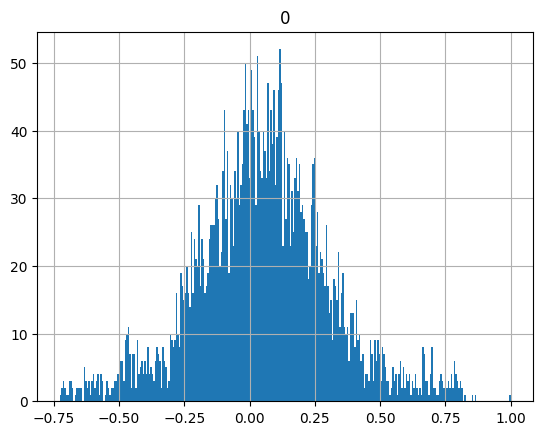

In [81]:
sim_df.sort_values(by=[0], axis=0, ascending=False).hist(bins=300)

In [59]:
fn='./result_files/cosine_similarities_wrt_{}.csv'.format(target_compound)
final_df=sim_df.sort_values(by=[0], axis=0, ascending=False).reset_index()
final_df.columns=['drugs','cosine_similarity']
final_df.to_csv(fn,sep=',',encoding='utf-8',index=False)